In [2]:
# Recommender system follows much from NLP, in terms of using embeddings and structure
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

from sklearn.utils import shuffle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Using the movie lens dataset (from https://grouplens.org/datasets/movielens/)
!wget https://files.grouplens.org/datasets/movielens/ml-20m.zip # 20 million ratings in this dataset

--2022-07-26 14:45:40--  https://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M   119MB/s    in 1.6s    

2022-07-26 14:45:41 (119 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]



In [4]:
!unzip -n ml-20m.zip # we want ratings.csv

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


In [5]:
df = pd.read_csv('ml-20m/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [6]:
# We cant trust the userId and movieId to be numbered 0...N-1, so make our own IDs
# If the IDs went 0, 1, 1000000, we would have nearly 1000000 vectors of wasted space in embedding matrix
# ID can also be a GUID, which cant map into our embedding properly
# Although we can make our own code, it is slow
# We can cast the userId column into a Categorical, which assigns integer codings starting at 0, then assign these codes to new column
df.userId = pd.Categorical(df.userId)
df['new_user_id'] = df.userId.cat.codes

In [7]:
# Same with movieId
df.movieId = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieId.cat.codes

In [8]:
df.head()

,userId,movieId,rating,timestamp,new_user_id,new_movie_id
0,1,2,3.5,1112486027,0,1
1,1,29,3.5,1112484676,0,28
2,1,32,3.5,1112484819,0,31
3,1,47,3.5,1112484727,0,46
4,1,50,3.5,1112484580,0,49


In [9]:
# Get user IDs, movie IDs, and ratings as separate arrays
user_ids = df['new_user_id'].values
movie_ids = df['new_movie_id'].values
ratings = df['rating'].values

In [11]:
# Get number of users and movies
N = len(set(user_ids))
M = len(set(movie_ids))
# Set embedding dimension (hyperparameter)
K = 10

In [12]:
# Make neural network
# User input (since inputs are a single integer, shape is 1)
u = Input(shape=(1,))
# Movie input
m = Input(shape=(1,))
# User embedding
u_emb = Embedding(N, K)(u) # output is (num_samples, 1, K) (for NLP instead of 1 we'd have T, but T = 1 here)
# Movie embedding
m_emb = Embedding(M, K)(m) # output is (num_samples, 1, K)
# Flatten both embeddings, so its now of size (num_samples, K)
u_emb = Flatten()(u_emb)
m_emb = Flatten()(m_emb)
# Concatenate user-movie embeddings into a feature vector
x = Concatenate()([u_emb, m_emb]) # now its (num_samples, 2K)

# Now that we have a feature vector, its just a regular ANN
# 2 approaches: go deep (more layers, less units) or go wide (less layers, more units)
# We opted for a single hidden layer with 1024 untis (wide)
x = Dense(1024, activation='relu')(x)
x = Dense(1)(x) # single output unit w/ no activation because regression

In [13]:
# Build model and compile
model = Model(inputs=[u, m], outputs=x)
model.compile(
    loss='mse',
    optimizer=SGD(lr=0.08, momentum=0.9)
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [14]:
# Split the data
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings) # shuffle the data in each array in corresponding order
Ntrain = int(0.8 * len(ratings)) # 80% training data, 20% test data
train_user, test_user = user_ids[:Ntrain], user_ids[Ntrain:]
train_movie, test_movie = movie_ids[:Ntrain], movie_ids[Ntrain:]
train_ratings, test_ratings = ratings[:Ntrain], ratings[Ntrain:]

# Center the data, using the mean of the train set (would need to scale back later when calculating MSE if we also divided by std dev)
avg_rating = train_ratings.mean()
train_ratings = train_ratings - avg_rating
test_ratings = test_ratings - avg_rating

In [15]:
r = model.fit(
    x=[train_user, train_movie],
    y=train_ratings,
    epochs=25,
    batch_size=1024, # helps each epoch run faster
    verbose=2, # goes a bit faster when not printing progress bar
    validation_data=([test_user, test_movie], test_ratings)
)

Epoch 1/25
15626/15626 - 66s - loss: 0.7771 - val_loss: 0.7219 - 66s/epoch - 4ms/step
Epoch 2/25
15626/15626 - 53s - loss: 0.7015 - val_loss: 0.7026 - 53s/epoch - 3ms/step
Epoch 3/25
15626/15626 - 53s - loss: 0.6785 - val_loss: 0.6832 - 53s/epoch - 3ms/step
Epoch 4/25
15626/15626 - 53s - loss: 0.6632 - val_loss: 0.6757 - 53s/epoch - 3ms/step
Epoch 5/25
15626/15626 - 49s - loss: 0.6538 - val_loss: 0.6712 - 49s/epoch - 3ms/step
Epoch 6/25
15626/15626 - 53s - loss: 0.6428 - val_loss: 0.6640 - 53s/epoch - 3ms/step
Epoch 7/25
15626/15626 - 53s - loss: 0.6259 - val_loss: 0.6506 - 53s/epoch - 3ms/step
Epoch 8/25
15626/15626 - 49s - loss: 0.6112 - val_loss: 0.6443 - 49s/epoch - 3ms/step
Epoch 9/25
15626/15626 - 49s - loss: 0.6013 - val_loss: 0.6400 - 49s/epoch - 3ms/step
Epoch 10/25
15626/15626 - 49s - loss: 0.5928 - val_loss: 0.6361 - 49s/epoch - 3ms/step
Epoch 11/25
15626/15626 - 49s - loss: 0.5846 - val_loss: 0.6338 - 49s/epoch - 3ms/step
Epoch 12/25
15626/15626 - 49s - loss: 0.5765 - val_l

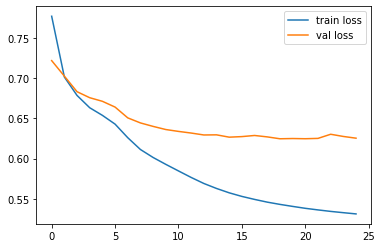

In [16]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [17]:
# Is this on par with other approaches?
# See data science stack exchange for others' results
# Take square root of val loss/MSE (which is squared)
np.sqrt(0.6259)
# yes

0.7911384202527394